# PathFinding Data PreProcessing
* find subject data
* find experiment and eyetracking files
* combine experiment files for single subject to consolidate
* combine eyetracking files for single subject and pre-process
* performance analysis of PathFinding experiments

## Configuration

In [1]:
# General configuration
import os

# data_directory: str
#     Path to a directory to store data.
data_directory = '.'

# install_missing_packages: bool
#     A flag indicating if missing packages should be automatically installed
install_missing_packages = True

# use_conda: bool
#     A flag indicating if conda should be used for software installation.
#     If False, pip will be used. The default is to use conda if jupyter
#     is run in a conda environment.
use_conda = 'CONDA_EXE' in os.environ

## Checking for missing packages

In [2]:
import importlib

def check_package(package, pip_pkg: str = None, conda_pkg: str = None):
    """Check if a given package is installed. If missing install
    it (if global flag `install_missing_packages` is True) either with
    pip or with conda (depending on `use_conda`).
    """
    if importlib.util.find_spec(package) is not None:
        return  # ok, package is already installed

    if not install_missing_packages:
        raise RuntimeError(f"{package} is not installed!")

    if use_conda:
        import conda.cli
        conda.cli.main('conda', 'install',  '-y', conda_pkg or package)
    else:
        import subprocess
        import sys            
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_pkg or package])
        
# This is to exit cells without error tracebacks (cosmetic purpose)
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## Creating the required environment (skip if already done)

Running the following cell will create a file graphs.yml that can be used to setup a conda environment containing the required packages. If you already downloaded the file from my GitHub, skip the next cell and create the env directly from it.

In [3]:
%%writefile graphs.yml
name: graphs
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - scikit-image
  - opencv
  - networkx
  - pandas
  - statsmodels

Writing graphs.yml


### Environment Creation
To create the environment, open the terminal, go to the directory where you stored the graphs.yml file (the directory of the notebook) and type
conda env create -f graphs.yml
After running this command you have to activate the environment (Linux/MacOS: conda activate graphs, Windows: activate graphs) and then reopen the notebook in that environment.

## Main Part

### Imports and directory information

In [1]:
import os
import cv2
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import glob
import scipy.cluster.vq as clusters
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#from sklearn.preprocessing import normalize
from pandas.plotting import autocorrelation_plot as AC_plot 
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from skimage.filters import gaussian
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import LinearSegmentedColormap
import time

In [22]:
OG_DATA_PATH = './'

condition = 'Dyadic' # Single, Dyadic, SingleC
DATA_PATH = './Data {}/'.format(condition)
LAB_DATA_PATH = "D:/StefanSpaRe/DataBackUp/seahavenlab/"
LAB_DATA_PATH += condition.lower() + '/';
DATA_PATH = LAB_DATA_PATH # Comment out when not in lab

# print(LAB_DATA_PATH);
RESSOURCES_PATH = './Ressources/'
#houselist 
house_file = RESSOURCES_PATH + 'building_collider_list.csv'
try:
    houselist = pd.read_csv(house_file)
except:
    print('HouseList could not be loaded!')

PROCESSED_DATA_PATH = './Results/' + condition + '/'
PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)


# Extracting all subject IDs from the data folder
# Getting the Folder without hidden files in ascending order 
DATA_FOLDER = sorted([f for f in os.listdir(DATA_PATH) if not f.startswith('.')], key=str.lower)

subIDs = []
for sub in DATA_FOLDER:
    if sub[0].isdigit():
        subIDs.append(int(sub[0:4]))
    else:
        pass
subIDs = np.unique(subIDs)

#subIDs = subIDs[:3]
#subIDs = [1023] # remove to do for all subIDs
print(subIDs)

[1004 1005 1008 1011 1013 1017 1018 1021 1022 1023 1054 1055 1057 1058
 1069 1074]


# Combining Pathfinding Experiment Files per Subject

In [7]:
EXPT_FILE_ATTRS = ['ParticipantID', 'PathsReversed', 'IsDyadic', 'IsLeader'];


def map_dict(a_dictionary):
    a_subset = {key: value for key, value in a_dictionary.items() if key in EYE_FILE_ATTRS};
    return a_subset;

# For each subject in subject ID folder, combine all experiment files
# and save as a unified final experiment file in Result folder
for sub in subIDs:
    # Get all files for subject
    SUB_FILES = list(filter(lambda x: str(sub)+"_" in x, DATA_FOLDER));
    # Sort files into experiment files and eyetracking files
    EYETRACKING_FILES = list(filter(lambda x: 'EyeTracking' in x, SUB_FILES));
    EYETRACKING_FILES.sort();
    
    EXPT_FILES = list(filter(lambda x: condition + 'PathFinding' in x, SUB_FILES));
    EXPT_FILES.sort();
    
    EXPT_DATA = {};
        
    # For each experiment file
    for expt_file in EXPT_FILES:
        
        # Read JSON data
        with open(DATA_PATH + expt_file) as f:
            try:
                subject_session = json.loads(f.read())
            except:
                print("\tJSON file " + expt_file + " is not valid!")
                continue;
        
        # If there are more than one experiment files, combine the data of the paths if the 
        # other trial and subject information matches
        if len(EXPT_DATA) > 0:
            print([subject_session[x] for x in EXPT_FILE_ATTRS]);
            print([EXPT_DATA[x] for x in EXPT_FILE_ATTRS]);
            if(not all([subject_session[x] == EXPT_DATA[x] for x in EXPT_FILE_ATTRS])):
                raise Exception("Experiment File Data " + expt_file + " Does Not Match!")
            else:
                EXPT_DATA['Concatenated'] = True;
                
                EXPT_DATA['TrialData'] += subject_session['TrialData'];
        
        else:
            EXPT_DATA = subject_session;
            EXPT_DATA['Concatenated'] = False;
        
    # Check if correct number of paths present in experiment file
    if len(EXPT_DATA['TrialData']) != 10:
        raise Exception("Incorrent number of paths in file for Subject " + str(sub));
        break;
        
    # Save the final combined file in results to be accessed by eyetracking collection script
    expt_file_name = PROCESSED_DATA_PATH + str(sub) + "_"+condition+"Pathfinding_Final.json";
    with open(expt_file_name, 'w') as fp:
        json.dump(EXPT_DATA, fp);
    EXPT_DATA = {};

print("Done")

['1008', False, True, True]
['1008', False, True, True]
['1021', True, True, True]
['1021', True, True, True]
['1022', True, True, False]
['1022', True, True, False]
['1058', False, True, False]
['1058', False, True, False]
Done


In [4]:
import random


# Store Time limits for each path condition
path_time_limits_A = [300, 305, 234, 332, 268, 394, 152, 383, 332];
path_time_limits_B = path_time_limits_A.copy();
path_time_limits_B.reverse();


# Leader : follower map
dyadic_pair_map = {
    '1021' : '1022',
    '1023' : '1013',
    '1005' : '1055',
    '1074' : '1069',
    '1008' : '1058',
    '1054' : '1004',
    '1011' : '1017',
    '1018' : '1057'
}

# Generate random session IDs to group leader and follower from same session easily in analysis
dyadic_session_ids = {}
for leader in dyadic_pair_map.keys():
    _id = random.randint(1000,9999);
    dyadic_session_ids[leader] = _id;
    dyadic_session_ids[dyadic_pair_map[leader]] = _id;
    
print(dyadic_session_ids);

{'1021': 6964, '1022': 6964, '1023': 9782, '1013': 9782, '1005': 7830, '1055': 7830, '1074': 3039, '1069': 3039, '1008': 9109, '1058': 9109, '1054': 2289, '1004': 2289, '1011': 1217, '1017': 1217, '1018': 5358, '1057': 5358}


### Combine the eyetracking data
* Loop through all subjects
* extract the session data
* combine the data
* save it

In [8]:
# --------- Preparation ---------

Session_save_bool = False # set to True if you want to save each individual session as csv
Exploration_save_bool = True # set to True if you want to save the complete exploration as csv#
Subject_Info_save_bool = True # set to True if you want to save the subject data as csv

subcount = 0
graffity_replaced_count = 0
removed_body_hits = 0
removed_nohouse_hits = 0
removed_duplicates = 0

landmarks = ['Castle-TaskBuilding_56',
             'Church-TaskBuilding_16',
             'HighSilo-TaskBuilding_49',
             'Windmill-TaskBuilding_10_1',
             'crane_1',
             'crane_2']

garages_to_stay = ['Garage_185', 
                   'Garage_224', 
                   'Garage_235',  
                   'Garage_86', 
                   'Garage_98']

# column name list for dataframe
col_names =  ['PathNumber',
          'timeStampDataPointStart',
          'timeStampDataPointEnd',
          'serverTimeStampDataPointStart',
          'serverTimeStampDataPointEnd',
          'hitObjectColliderName', 
              'ordinalOfHit',
              'BitMask',
              'hitPointOnObject.x',
              'hitPointOnObject.y',
              'hitPointOnObject.z',
              'hitObjectColliderBoundsCenter.x',
              'hitObjectColliderBoundsCenter.y',
              'hitObjectColliderBoundsCenter.z',
              'transformed_collidercenter_x',
              'transformed_collidercenter_y'
              'hmdPosition.x',
              'hmdPosition.y',
              'hmdPosition.z']



NoHit_dict = {'hitObjectColliderName': 'NoHit',
              'ordinalOfHit': '1'}

# Remove machine time stamps if single
if 'Single' in condition:
    col_names.pop(3);
    col_names.pop(3);

subject_cols = ['SubjectID',
                'Total Rows Combined',
                'Removed Body Hits', 
                'Removed Graffiti Hits', 
                'Replaced NoHouse Hits',
                'DataLoss BitMask', 
                'DataLoss NoHits',
                'DataLoss Combined']

subject_data_df = pd.DataFrame(columns=subject_cols)


# --------------------------- MAIN PART ---------------------------


# --------- first layer - subject loop ---------

# TODO: Phone and follower colliders
for subject in subIDs:
    subcount +=1
    print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))
    
    # Create empty dataframe for later concatenation
    complete_exploration_df = pd.DataFrame(columns = col_names)
    
    # get the data files according to the subject
    subject_folder = sorted([f for f in DATA_FOLDER 
                             if f.startswith(str(subject)+'_EyeTrackingData_')], 
                            key=str.lower) 
    
    # the following works as long as the data name format is as follows:
    # 'subjectID'_Expl_S_'SessionNumber'_ET_'EyeTrackingSessionNumber'_'UnixTimestamp'.json
    folder_files = list()
       
    # loop through the subject folder and save all numbers
    for file in subject_folder:
        folder_files.append(re.findall(r'\d+', file))
    
    if len(folder_files) == 0:
        # raise Exception("No eyetracking files in " + condition +" condition for subject " + str(subject))
        print("No eyetracking files in " + condition +" condition for subject " + str(subject) +". Skipping.")
        continue;
    # Extract all SubIDs (only one), (and Timestamps)
    SubID, UnixTimestamp1, _ = map(list, zip(*folder_files))
    
    # Get the experiment JSON file for the subject
    sub_expt_data = {}
    sub_expt_file_name = PROCESSED_DATA_PATH + str(subject) + "_"+condition+"Pathfinding_Final.json";
    try:
        with open(sub_expt_file_name, 'r') as fp:
            sub_expt_data = json.load(fp);
    except:
        print("Could not read experiment file for subject " + str(subject));
        continue;
    
# --------- second layer - path loop ---------
    s = 0;
    complete_hitpoints_df = pd.DataFrame(columns = col_names)
    previous_path_num = -1.0;
    
    sample_freq_total = 0;
    time_elapsed_total = 0;
    hits_total = 0;
    # loop over separate eye tracking sessions
    for path_session in subject_folder:
        s+=1
        #print("\tSession " + str(s) + " started")

            # open the JSON file as dictionary
        with open(DATA_PATH + path_session) as f:
            try:
                subject_session = json.loads(f.read())
            except:
                print("\tJSON file " + path_session + " is not valid!")

        hitpoint_list = list() # create hitpoint list
        
        # check if trial is valid:
        trial_valid = subject_session['trials'][0]['trialIsValid']
        if not trial_valid:
            print("Excluding " + path_session + " because trial is not valid!");
            continue;
        
        sub_id = subject_session['trials'][0]['participantId']
        if str(sub_id) != str(subject):
            print("Excluding " + path_session + " because subject IDs don't match!");
            continue;
        
        # start timestamp of the session 
        start_time = subject_session['trials'][0]['timeTrialMeasurementStarted']
        
        # get trial id (path number)
        path_num = subject_session['trials'][0]['trialId']
        
        expt_path_start_time = sub_expt_data['TrialData'][path_num]['StartMachineTimeStamp'];
        expt_path_end_time = sub_expt_data['TrialData'][path_num]['EndMachineTimeStamp'];
        
        machine_time_stamp_diff = 0.0;
        if 'Single' not in condition and path_num != previous_path_num:
            expt_path_start_srvtime_mS = sub_expt_data['TrialData'][path_num]['StartServerTimeStamp'];
            machine_time_stamp_diff = expt_path_start_time - expt_path_start_srvtime_mS / 1000;
            previous_path_num = path_num;

        # amount of datapoints 
        Len_subses = len(subject_session['trials'][0]['dataPoints'])

        # for loop appending each data point rayCastHit Data
        # afterwards adding the timestamp to the dict 
        # if there is (1) no raycast hit appending NoHit Dict
        hits = 0
        start_idx = 0
        end_idx = 0
        sec_errors = 0
        
        # --------------- First order hits! ---------------
        for each in subject_session['trials'][0]['dataPoints']:
            # ----- account for erroneous duplicates ----- 
            if hitpoint_list == []:
                pass
            elif each['timeStampDataPointEnd'] == hitpoint_list[len(hitpoint_list)-1]['timeStampDataPointEnd']:
                removed_duplicates += 1
                # skip the entry 
                continue
                
            # account for noHits 
            if each['rayCastHitsCombinedEyes'] == []:
                hitpoint_list.append(NoHit_dict.copy())
                # set index for new entry
                idx = len(hitpoint_list)-1
                hitpoint_list[idx]['PathNumber'] = path_num
                hitpoint_list[idx]['timeStampDataPointStart'] = each['timeStampDataPointStart']# - start_time
                
                hitpoint_list[idx]['timeStampDataPointEnd'] = each['timeStampDataPointEnd'] #- start_time
                hitpoint_list[idx]['BitMask'] = each['combinedGazeValidityBitmask']
                # hmdPosition
                hitpoint_list[idx]['hmdPosition.x'] = each['hmdPosition']['x']
                hitpoint_list[idx]['hmdPosition.y'] = each['hmdPosition']['y']
                hitpoint_list[idx]['hmdPosition.z'] = each['hmdPosition']['z']
            else:
                # append data point
                hitpoint_list.append(each['rayCastHitsCombinedEyes'][0]) 
                # add path number, timestamp and bitmask
                idx = len(hitpoint_list)-1
                
                hitpoint_list[idx]['PathNumber'] = path_num
                
                current_collider = hitpoint_list[idx]['hitObjectColliderName']
                
                # Exclude the data point if it lies outside of the times for a path
                # TODO: Should this be excluded? Perhaps do a per-subject-analysis of how many points
                #           would end up excluded?
                if each['timeStampDataPointStart'] < expt_path_start_time or each['timeStampDataPointStart'] > expt_path_end_time:
                    hitpoint_list[idx]['PathNumber'] += 0; # Change this to some other high number to exclude


                # Add the server time stamp if dyadic
                if 'Single' not in condition:
                    hitpoint_list[idx]['serverTimeStampDataPointStart'] = (each['timeStampDataPointStart'] - machine_time_stamp_diff) * 1000.0;
                    hitpoint_list[idx]['serverTimeStampDataPointEnd'] = (each['timeStampDataPointEnd'] - machine_time_stamp_diff) * 1000.0;
                hitpoint_list[idx]['timeStampDataPointStart'] = each['timeStampDataPointStart'] #- start_time
                hitpoint_list[idx]['timeStampDataPointEnd'] = each['timeStampDataPointEnd'] #- start_time
                hitpoint_list[idx]['BitMask'] = each['combinedGazeValidityBitmask']
                
                # Add HMD position
                
                hitpoint_list[idx]['hmdPosition.x'] = each['hmdPosition']['x']
                hitpoint_list[idx]['hmdPosition.y'] = each['hmdPosition']['y']
                hitpoint_list[idx]['hmdPosition.z'] = each['hmdPosition']['z']
                # ----- CONDITIONS FOR CLEANING -----
                
                        
                # ----- Merging obsolete colliders -----
                if current_collider in list(houselist.source_collider_name):
                    
                    collider_data = houselist[houselist.source_collider_name==current_collider]


                    hitpoint_list[idx]['hitObjectColliderName'] = \
                        collider_data.target_collider_name.values[0]

                    # change collider coordinates
                    hitpoint_list[idx]['hitObjectColliderBoundsCenter.x'] = \
                        collider_data['ColliderBoundsCenter.x'].values[0]
                    hitpoint_list[idx]['hitObjectColliderBoundsCenter.y'] = \
                        collider_data['ColliderBoundsCenter.y'].values[0]
                    hitpoint_list[idx]['hitObjectColliderBoundsCenter.z'] = \
                        collider_data['ColliderBoundsCenter.z'].values[0]    
                    hitpoint_list[idx]['transformed_collidercenter_x'] = \
                        collider_data['transformed_collidercenter_x'].values[0]
                    hitpoint_list[idx]['transformed_collidercenter_y'] = \
                        collider_data['transformed_collidercenter_y'].values[0]

                # ----- NoHouse Hits -----
                # check if the collider name is a member of the houselist - if not: rename to NoHouse 
                elif current_collider not in list(houselist.source_collider_name) \
                and (current_collider.startswith('Graffity_')) == False:                    
                    hitpoint_list[idx]['hitObjectColliderName'] = 'NoHouse'
                    

                # QUESTION: What's happening here?
                else:
                    try:
                        hitpoint_list[idx]['hitObjectColliderBoundsCenter.x'] = \
                            collider_data['ColliderBoundsCenter.x'].values[0]
                        hitpoint_list[idx]['hitObjectColliderBoundsCenter.y'] = \
                            collider_data['ColliderBoundsCenter.y'].values[0]
                        hitpoint_list[idx]['hitObjectColliderBoundsCenter.z'] = \
                            collider_data['ColliderBoundsCenter.z'].values[0]   
                        hitpoint_list[idx]['transformed_collidercenter_x'] = \
                            collider_data['transformed_collidercenter_x'].values[0]
                        hitpoint_list[idx]['transformed_collidercenter_y'] = \
                            collider_data['transformed_collidercenter_y'].values[0]
                    except:
                        pass
            if hits == 0: start_idx = idx;
            hits += 1;
            # --------------- Second order hits! ---------------
            try: 
                # append data point of second raycast hit if it exists
                hitpoint_list.append(each['rayCastHitsCombinedEyes'][1])
                # add Path number, timestamp and bitmask
                idx = len(hitpoint_list)-1
                hitpoint_list[idx]['PathNumber'] = hitpoint_list[idx-1]['PathNumber'];
                current_collider = hitpoint_list[idx]['hitObjectColliderName']
                # Add the server time stamp if dyadic
                if 'Single' not in condition:
                    hitpoint_list[idx]['serverTimeStampDataPointStart'] = (each['timeStampDataPointStart'] - machine_time_stamp_diff) * 1000.0;
                    hitpoint_list[idx]['serverTimeStampDataPointEnd'] = (each['timeStampDataPointEnd'] - machine_time_stamp_diff) * 1000.0;
                
                hitpoint_list[idx]['timeStampDataPointStart'] = each['timeStampDataPointStart']# - start_time
                hitpoint_list[idx]['timeStampDataPointEnd'] = each['timeStampDataPointEnd']# - start_time
                hitpoint_list[idx]['BitMask'] = each['combinedGazeValidityBitmask']
                
                # ----- Merging obsolete colliders -----
                if current_collider in list(houselist.source_collider_name):

                    collider_data = houselist[houselist.source_collider_name==current_collider]


                    hitpoint_list[idx]['hitObjectColliderName'] = \
                        collider_data.target_collider_name.values[0]

                    # change collider coordinates
                    hitpoint_list[idx]['hitObjectColliderBoundsCenter.x'] = \
                        collider_data['ColliderBoundsCenter.x'].values[0]
                    hitpoint_list[idx]['hitObjectColliderBoundsCenter.y'] = \
                        collider_data['ColliderBoundsCenter.y'].values[0]
                    hitpoint_list[idx]['hitObjectColliderBoundsCenter.z'] = \
                        collider_data['ColliderBoundsCenter.z'].values[0]    
                    hitpoint_list[idx]['transformed_collidercenter_x'] = \
                        collider_data['transformed_collidercenter_x'].values[0]
                    hitpoint_list[idx]['transformed_collidercenter_y'] = \
                        collider_data['transformed_collidercenter_y'].values[0]

                # ----- NoHouse Hits -----
                # check if the collider name is a member of the houselist - if not: rename to NoHouse 
                elif current_collider not in list(houselist.source_collider_name) \
                and (current_collider.startswith('Graffity_')) == False:
                    
                    hitpoint_list[idx]['hitObjectColliderName'] = 'NoHouse'

                else:
                    try:
                        hitpoint_list[idx]['hitObjectColliderBoundsCenter.x'] = \
                            collider_data['ColliderBoundsCenter.x'].values[0]
                        hitpoint_list[idx]['hitObjectColliderBoundsCenter.y'] = \
                            collider_data['ColliderBoundsCenter.y'].values[0]
                        hitpoint_list[idx]['hitObjectColliderBoundsCenter.z'] = \
                            collider_data['ColliderBoundsCenter.z'].values[0]   
                        hitpoint_list[idx]['transformed_collidercenter_x'] = \
                            collider_data['transformed_collidercenter_x'].values[0]
                        hitpoint_list[idx]['transformed_collidercenter_y'] = \
                            collider_data['transformed_collidercenter_y'].values[0]
                    except:
                        pass
                
                # if the first order hit was a NoHouse hit, but the second was not
                if hitpoint_list[idx-1]['hitObjectColliderName'] == 'NoHouse' \
                and hitpoint_list[idx]['hitObjectColliderName'] != 'NoHouse':
                    removed_nohouse_hits += 1

                    hitpoint_list[idx]['ordinalOfHit'] = 1
                    
                    # use hmdPosition of first order hit
                    if "hmdPosition.x" in hitpoint_list[idx-1]:
                        hitpoint_list[idx]['hmdPosition.x'] = hitpoint_list[idx-1]['hmdPosition.x']
                        hitpoint_list[idx]['hmdPosition.y'] = hitpoint_list[idx-1]['hmdPosition.y']
                        hitpoint_list[idx]['hmdPosition.z'] = hitpoint_list[idx-1]['hmdPosition.z']
                        
                    # and remove the first order hit
                    del hitpoint_list[idx-1]
                    idx -= 1

                    idx -= 1 # reset index for safety
                # ----- Body Hits -----
                # check if there is a 1 order Body hit, if yes: replace it with second order hit
                elif hitpoint_list[idx-1]['hitObjectColliderName'].lower() == 'body':
                    # if second order hit is not a body hit, replace first order hit
                    if hitpoint_list[idx]['hitObjectColliderName'].lower() != 'body':
                        removed_body_hits += 1

                        hitpoint_list[idx]['ordinalOfHit'] = 1
                        
                        # use hmdPosition of first order hit
                        if "hmdPosition.x" in hitpoint_list[idx-1]:
                            hitpoint_list[idx]['hmdPosition.x'] = hitpoint_list[idx-1]['hmdPosition.x']
                            hitpoint_list[idx]['hmdPosition.y'] = hitpoint_list[idx-1]['hmdPosition.y']
                            hitpoint_list[idx]['hmdPosition.z'] = hitpoint_list[idx-1]['hmdPosition.z']


                        # and remove the second order hit
                        del hitpoint_list[idx-1]
                        idx -= 1 # reset index for safety

                    # if second order hit is a body hit, replace first order hit with NoHit
                    else:
                        removed_body_hits += 1

                        # replace the first order hit data
                        hitpoint_list[idx-1]['hitObjectColliderName'] = 'NoHit'
                        hitpoint_list[idx-1]['hitPointOnObject.x'] = 'NaN'
                        hitpoint_list[idx-1]['hitPointOnObject.y'] = 'NaN'
                        hitpoint_list[idx-1]['hitPointOnObject.z'] = 'NaN'
                        hitpoint_list[idx-1]['hitObjectColliderBoundsCenter.x'] = 'NaN'
                        hitpoint_list[idx-1]['hitObjectColliderBoundsCenter.y'] = 'NaN'
                        hitpoint_list[idx-1]['hitObjectColliderBoundsCenter.z'] = 'NaN'
                        hitpoint_list[idx-1]['transformed_collidercenter_x'] = 'NaN'
                        hitpoint_list[idx-1]['transformed_collidercenter_y'] = 'NaN'

                        # and remove the second order hit
                        del hitpoint_list[idx]
                        idx -= 1

            except:
                sec_errors += 1;
                pass
        
        end_idx = idx;
        # REMOVING REMAINING GRAFFITY AND BODY HITS
        for index in range(len(hitpoint_list)):
            if hitpoint_list[index]['hitObjectColliderName'].lower() == 'body':
                removed_body_hits += 1
                hitpoint_list[index]['hitObjectColliderName'] = 'NoHit'
                hitpoint_list[index]['hitPointOnObject.x'] = 'NaN'
                hitpoint_list[index]['hitPointOnObject.y'] = 'NaN'
                hitpoint_list[index]['hitPointOnObject.z'] = 'NaN'
                hitpoint_list[index]['hitObjectColliderBoundsCenter.x'] = 'NaN'
                hitpoint_list[index]['hitObjectColliderBoundsCenter.y'] = 'NaN'
                hitpoint_list[index]['hitObjectColliderBoundsCenter.z'] = 'NaN'
                hitpoint_list[index]['transformed_collidercenter_x'] = 'NaN'
                hitpoint_list[index]['transformed_collidercenter_y'] = 'NaN'

            # check if there are Graffity Hits and rename them as the building they are on
            if hitpoint_list[index]['hitObjectColliderName'].startswith('Graffity_'):
                building_number = re.search(r'\d+', hitpoint_list[index]['hitObjectColliderName']).group()
                graffity_to_building = []


                # if the number is between 0 and 9, remove the 0
                building_number = str(int(building_number))

                for house in list(houselist.target_collider_name):
                    #check if the exact building number is in the houselist to replace graffity name
                    # additionally check that it's not a landmark or a garage to stay
                    if house.endswith('_' + building_number) \
                    and house not in landmarks \
                    and house not in garages_to_stay:
                        # check if the house name is already in the list
                        if house in graffity_to_building:
                            pass
                        else:
                            graffity_to_building.append(house)

                if len(graffity_to_building) == 1:
                    hitpoint_list[index]['hitObjectColliderName'] = graffity_to_building[0]
                    graffity_replaced_count += 1
                else:
                    print('Multiple houses with the same number! - Index: ' 
                          + str(index)
                          + ', ' 
                          + str(graffity_to_building))
        
        samp_freq = 0;
        try: 
            start_file_timestamp = hitpoint_list[start_idx]['timeStampDataPointStart']
            end_file_timestamp = hitpoint_list[end_idx]['timeStampDataPointStart']

            samp_freq = hits / (end_file_timestamp - start_file_timestamp)

            time_elapsed_total += end_file_timestamp - start_file_timestamp;
            sample_freq_total  += samp_freq;
            hits_total += hits;
        except:
            pass;
                
        # normalize the hitpoint dictionary to get dataframe
        hitpoints_df = pd.json_normalize(hitpoint_list)
        
        print("\tET: " + str(s) + " normalized. Sampling frequency: " + str(samp_freq))# + " Errors: " + str(sec_errors))
        complete_hitpoints_df = complete_hitpoints_df.append(hitpoints_df)

    
        # --------- Saving each Session ---------

        # If you want to save each session separately, set 'Session_save_bool' to True
        if Session_save_bool == True:
            try:
                if len(subject_data) > 0:
                    complete_hitpoints_df.to_csv(PROCESSED_DATA_PATH
                                                 + str(subject)
                                                 + "_" + condition
                                                 + "_CompleteHitpoints.csv")
                    print("\t"
                          + str(subject)
                          + " session "
                          + "_" + condition
                          + " saved ")
                else: 
                    print("\t"
                          + str(subject)
                          + " - Session "
                          + "_" + condition
                          + " is empty!")
            except:
                print("\tCould not save subject "
                      + str(subject)
                      + " session "
                      + "_" + condition
                      + "!")


    print("\tFor subject " + str(subject) + ", average sampling frequency is: " + str(hits_total / time_elapsed_total))
    # fill the complete exploration dataframe with the separate session data (combining the sessions)
    complete_exploration_df = complete_exploration_df.append(complete_hitpoints_df)
        
    # --------- Saving the Exploration ---------
    
    # If you want to save the exploration file, set 'Exploration_save_bool' to True
    if Exploration_save_bool == True:
        # saving the complete exploration
        try:
            complete_exploration_df.to_csv(PROCESSED_DATA_PATH + str(subject) + "_" + condition + "_CompleteHitpoints.csv")
            print("\t" + str(subject) + " " + condition + " eyetracking data saved")
        except:
            print("\tCould not save subject " + str(subject) + " " + condition + " eyetracking data!")
    
    print("\t" + str(subject) + " - Stats: ")
    print("\tRemoved Body Hits: " 
          + str(removed_body_hits) 
          + ' Removed Graffities: ' 
          + str(graffity_replaced_count) 
          + ' Replaced 1st NoHouse hits: ' 
          + str(removed_nohouse_hits))


    # Some information about the data
    bit_prop = np.sum(complete_exploration_df['BitMask'] != 3) \
        / len(complete_exploration_df)
    noHit_prop = np.sum(complete_exploration_df['hitObjectColliderName'] == 'NoHit') \
        / len(complete_exploration_df)
    noHouse_prop = np.sum(complete_exploration_df['hitObjectColliderName'] == 'NoHouse') \
        / len(complete_exploration_df)

    print("\tPortion of insufficient data quality (BitMask): " 
          + str("{:.2f}".format(100*bit_prop)) 
          + '%') 
    print("\tNoHits: " 
          + str("{:.2f}".format(100*noHit_prop)) 
          + '%')
    print("\tNoHouse: " 
          + str("{:.2f}".format(100*noHouse_prop)) 
          + '%')
    print("\tTotal missing data: " 
          + str("{:.2f}".format(100*(bit_prop + noHit_prop))) 
          + '%') 


    # fill the subject info dataframe
    subject_data_df.loc[subcount-1, 'SubjectID'] = subject
    subject_data_df.loc[subcount-1, 'Total Rows Combined'] = len(complete_exploration_df)
    subject_data_df.loc[subcount-1, 'Removed Body Hits'] = removed_body_hits
    subject_data_df.loc[subcount-1, 'Removed Graffiti Hits'] = graffity_replaced_count
    subject_data_df.loc[subcount-1, 'Replaced NoHouse Hits'] = removed_nohouse_hits
    subject_data_df.loc[subcount-1, 'DataLoss BitMask'] = bit_prop
    subject_data_df.loc[subcount-1, 'DataLoss NoHits'] = noHit_prop
    subject_data_df.loc[subcount-1, 'DataLoss Combined'] = bit_prop + noHit_prop

    if Subject_Info_save_bool == True:
        try:
            subject_data_df.to_csv(PROCESSED_DATA_PATH
                                           + "Subject_Data.csv", 
                                            index=False)

            print("Subject Data saved")
        except:
            print("Could not save subject data!")
print('Done')

Subject 1004 started - 1/16
	ET: 1 normalized. Sampling frequency: 63.90476323681872
	ET: 2 normalized. Sampling frequency: 62.52270945958642
	ET: 3 normalized. Sampling frequency: 62.83546561620932
	ET: 4 normalized. Sampling frequency: 63.53573631801185
	ET: 5 normalized. Sampling frequency: 62.684826115554316
	ET: 6 normalized. Sampling frequency: 61.92292808574309
	ET: 7 normalized. Sampling frequency: 63.03571002657786
	ET: 8 normalized. Sampling frequency: 62.06608747239516
	ET: 9 normalized. Sampling frequency: 62.62663393906159
	ET: 10 normalized. Sampling frequency: 62.96496376685783
	For subject 1004, average sampling frequency is: 62.770120033099914
	1004 Dyadic eyetracking data saved
	1004 - Stats: 
	Removed Body Hits: 0 Removed Graffities: 493 Replaced 1st NoHouse hits: 9029
	Portion of insufficient data quality (BitMask): 3.20%
	NoHits: 0.07%
	NoHouse: 89.57%
	Total missing data: 3.27%
Subject Data saved
Subject 1005 started - 2/16
	ET: 1 normalized. Sampling frequency: 6

	1022 Dyadic eyetracking data saved
	1022 - Stats: 
	Removed Body Hits: 0 Removed Graffities: 8197 Replaced 1st NoHouse hits: 87148
	Portion of insufficient data quality (BitMask): 2.77%
	NoHits: 0.23%
	NoHouse: 89.86%
	Total missing data: 3.00%
Subject Data saved
Subject 1023 started - 10/16
	ET: 1 normalized. Sampling frequency: 64.05630906513254
	ET: 2 normalized. Sampling frequency: 63.89173587017132
	ET: 3 normalized. Sampling frequency: 65.47687967316371
	ET: 4 normalized. Sampling frequency: 65.31237158386773
	ET: 5 normalized. Sampling frequency: 64.81630771401433
	ET: 6 normalized. Sampling frequency: 64.05420751696305
	ET: 7 normalized. Sampling frequency: 64.6128563898522
	ET: 8 normalized. Sampling frequency: 64.5274354061799
	ET: 9 normalized. Sampling frequency: 64.63784496480848
	ET: 10 normalized. Sampling frequency: 65.02760299807407
	For subject 1023, average sampling frequency is: 64.69046131045869
	1023 Dyadic eyetracking data saved
	1023 - Stats: 
	Removed Body Hit

In [86]:
Result_df = pd.read_csv(PROCESSED_DATA_PATH+'1023_Single_CompleteHitpoints.csv')

excluded_df = Result_df[Result_df.PathNumber < 20]

print("Results after excluding outside path hitpoints: ")
# Some information about the data
bit_prop = np.sum(excluded_df['BitMask'] != 3) \
    / len(excluded_df)
noHit_prop = np.sum(excluded_df['hitObjectColliderName'] == 'NoHit') \
    / len(excluded_df)
noHouse_prop = np.sum(excluded_df['hitObjectColliderName'] == 'NoHouse') \
    / len(excluded_df)

print("\tPortion of insufficient data quality (BitMask): " 
      + str("{:.2f}".format(100*bit_prop)) 
      + '%') 
print("\tNoHits: " 
      + str("{:.2f}".format(100*noHit_prop)) 
      + '%')
print("\tNoHouse: " 
      + str("{:.2f}".format(100*noHouse_prop)) 
      + '%')
print("\tTotal missing data: " 
      + str("{:.2f}".format(100*(bit_prop + noHit_prop))) 
      + '%') 


Results after excluding outside path hitpoints: 
	Portion of insufficient data quality (BitMask): 3.89%
	NoHits: 0.39%
	NoHouse: 65.14%
	Total missing data: 4.28%


In [14]:
Result_df = pd.read_csv('./Results/Single/1023_Single_CompleteHitpoints.csv')

In [15]:
Result_df

,Unnamed: 0,PathNumber,timeStampDataPointStart,timeStampDataPointEnd,hitObjectColliderName,ordinalOfHit,BitMask,hitPointOnObject.x,hitPointOnObject.y,hitPointOnObject.z,hitObjectColliderBoundsCenter.x,hitObjectColliderBoundsCenter.y,hitObjectColliderBoundsCenter.z,transformed_collidercenter_x,transformed_collidercenter_yhmdPosition.x,hmdPosition.y,hmdPosition.z,hmdPosition.x,transformed_collidercenter_y
0,0,0,1.620116e+09,1.620116e+09,NoHouse,1,3,251.315308,-0.877272,170.721466,251.851456,-2.287690,171.080597,NaN,NaN,-0.494329,170.390976,250.958450,NaN
1,1,0,1.620116e+09,1.620116e+09,NoHouse,2,3,252.663849,-2.399850,172.152802,39.257874,-4.408301,51.768860,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,1.620116e+09,1.620116e+09,NoHouse,1,3,251.315308,-0.877272,170.721466,251.851456,-2.287690,171.080597,NaN,NaN,-0.494329,170.390976,250.958450,NaN
3,3,0,1.620116e+09,1.620116e+09,NoHouse,2,3,252.663849,-2.399850,172.152802,39.257874,-4.408301,51.768860,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,1.620116e+09,1.620116e+09,NoHouse,1,3,252.691284,-2.400710,172.184113,39.257874,-4.408301,51.768860,NaN,NaN,-0.494738,170.429337,250.988846,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131823,10287,9,1.620117e+09,1.620117e+09,NoHouse,2,3,-282.919861,-0.628130,-180.625015,-491.456299,18.698456,-597.844604,NaN,NaN,NaN,NaN,NaN,NaN
131824,10288,9,1.620117e+09,1.620117e+09,NoHouse,1,3,-282.872314,-0.487734,-180.359741,-217.756897,-2.905127,-288.595245,NaN,NaN,1.368883,-177.683304,-282.338440,NaN
131825,10289,9,1.620117e+09,1.620117e+09,NoHouse,2,3,-282.912537,-0.626187,-180.557816,-491.456299,18.698456,-597.844604,NaN,NaN,NaN,NaN,NaN,NaN
131826,10290,9,1.620117e+09,1.620117e+09,NoHouse,1,3,-282.881683,-0.488985,-180.404495,-217.756897,-2.905127,-288.595245,NaN,NaN,1.367091,-177.778519,-282.382690,NaN


In [41]:
sub_data_df = pd.read_csv('./Results/Single/Subject_Data.csv')
sub_data_df
#TODO: Discuss subject data with Team to see if okay

,SubjectID,Total Rows Combined,Removed Body Hits,Removed Graffiti Hits,Replaced NoHouse Hits,DataLoss BitMask,DataLoss NoHits,DataLoss Combined
0,1004,495307,15696,9042,37664,0.057736,0.016083,0.073819
1,1005,393494,25122,12524,63074,0.059632,0.012661,0.072293
2,1008,195403,30081,14883,78341,0.156825,0.033613,0.190437
3,1010,334651,34223,19000,105246,0.080057,0.029138,0.109194
4,1011,311928,42050,22805,127461,0.038143,0.015096,0.053240
5,1013,311802,49895,27509,155573,0.036844,0.019243,0.056087
6,1017,519459,62270,35081,196408,0.020204,0.014615,0.034819
7,1018,365926,74519,39079,228393,0.066472,0.016058,0.082530
8,1019,281116,82814,42585,248981,0.082532,0.015524,0.098056
9,1021,360115,94242,47446,273580,0.023495,0.014687,0.038182


In [11]:
print("data points excluded for 1023: ");
(Result_df['PathNumber'] > 20).value_counts()


data points excluded for 1023: 


False    245298
Name: PathNumber, dtype: int64

### Condense the data and create gaze lists
* Do Runlength Encoding on the colliderName column to reduce the data size

### Interpolation of the data to minimize cut clustering (based on Walter, 2021)
* Interpolation criteria:
    * there are <=21 consecutive NoHit Samples
    * they are surrounded by two clusters on the same collider

In [14]:
# --------- Preparation ---------
RLE_save_bool = False # if you want to save the condensed dataframe
Interpolation_save_bool = True # if you want to save the condensed dataframe
Subject_Info_save_bool = True # set to True if you want to save the subject data as csv

# dataframe for time deviations
time_df = pd.DataFrame()

# column names for the condensed df
# TODO: Add hmdPositions to interpolation df
condense_col_names = ['PathNumber', 
                      'ColliderName',
                      'Samples',
                      'timeDiff']

# column names for the interpolation df
interpol_col_names = ['PathNumber',
                      'ColliderName',
                      'Samples',
                      'timeDiff',
                      'Index']

subcount = 0 # count subjects

fixation_time = 0.2333333



# open the subject data csv
with open(PROCESSED_DATA_PATH + "Subject_Data.csv") as f:
    try:
        subject_data_df = pd.read_csv(f)
    except:
        print("Subject Data file could not be loaded!")



# --------- MAIN PART ---------
# load the files 
for subject in subIDs:
    subcount +=1
    print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))
    
    
    # get the data files according to the subject
    subject_folder = sorted([f for f in PROCESSED_DATA_FOLDER 
                             if f.startswith(str(subject)+'_'+condition +'_CompleteHitpoints')], key=str.lower)
    print(subject_folder)
    if len(subject_folder) != 0:
    
        # open the JSON file as dictionary
        with open(PROCESSED_DATA_PATH + subject_folder[0]) as f:
            try:
                data = pd.read_csv(f)
            except:
                print("\tCSV file " + subject_folder[0] + " is not valid!")
    else:
        print('Subject ' + str(subject) + ' has no data file!')
        continue 
           
    data = data[data.ordinalOfHit==1]
    data.reset_index(inplace=True, drop=False)
    
    # --------- TIME DEVIATION PART ---------
    for path_num in range(10):
        # get the session data 
        session_data = data[data.PathNumber == path_num].reset_index(drop=True)
        
        # create temporal dataframe, add session and calculate the difference between end timestamps
        temp_df = pd.DataFrame(index=range(len(session_data)), columns=['PathNumber', 'timeDiff'])

        temp_df.PathNumber = session_data.PathNumber

        temp_df.timeDiff = session_data['timeStampDataPointEnd'] - session_data['timeStampDataPointEnd'].shift()

        # append temporal df to the time df
        time_df = time_df.append(temp_df)
        
    # reseting the index
    time_df.reset_index(drop=True, inplace=True)
    
    # check for transition values and set to the median
    time_df.timeDiff[time_df.timeDiff.isnull()] = np.nanmedian(temp_df.timeDiff)
    
    # adding the time df to the main data df
    data['time_Diff'] = time_df.timeDiff
    
    # --------- CONDENSE PART ---------
    
    condense_RLE_df = pd.DataFrame(columns=condense_col_names)
    for path_num in range(10):
        # dataframe for counting successive appearances
        path_data = data[data.PathNumber == path_num].reset_index(drop=True);
        condense_df = pd.DataFrame(index=range(len(path_data)), columns=condense_col_names)
        condense_df.PathNumber = path_data.PathNumber
        condense_df.ColliderName = path_data.hitObjectColliderName
        # count successive appearances by comparing with shifted df + cumsum + cumcount
        condense_df['Samples'] = \
        path_data['hitObjectColliderName'].groupby((path_data['hitObjectColliderName'] 
                                               != path_data['hitObjectColliderName'].shift()).cumsum()).cumcount() + 1


        # use the condense_df to sum up unique countings
        condense_count = (path_data['hitObjectColliderName'] != path_data['hitObjectColliderName'].shift()).cumsum()
        ColliderNames_df = pd.DataFrame()
        Samples_df = pd.DataFrame()
        TimeDiff_df = pd.DataFrame()

        # find the respective collidername by searching for the first (and possibly only) appearance
        ColliderNames_df['ColliderName'] = condense_df[condense_df.Samples==1].ColliderName
        ColliderNames_df['PathNumber'] = condense_df[condense_df.Samples==1].PathNumber
        ColliderNames_df.reset_index(inplace=True, drop=True)
        # count the actual successive appearances by grouping by the unique countings in condense_count
        Samples_df['Samples'] = condense_df.groupby(condense_count).ColliderName.count()
        Samples_df.reset_index(inplace=True, drop=True)

        TimeDiff_df['TimeDiff'] = data.groupby(condense_count).time_Diff.sum()
        TimeDiff_df.reset_index(drop=True, inplace=True)

        # join the Dataframes 
        condense_temp_RLE = ColliderNames_df.join(Samples_df)
        condense_temp_RLE['timeDiff'] = TimeDiff_df['TimeDiff']
        
        condense_RLE_df = condense_RLE_df.append(condense_temp_RLE, ignore_index=True)
    
    
    # --------- INTERPOLATION PART ---------
    condense_data = condense_RLE_df.copy() #copy for safety
    
    current_collider = 'X' # the reference collidername for interpolation
    previous_pathnum = -1 # the reference collidername for interpolation
    last_time = 0 # the reference time sum for interpolation 
    last_samples = 0 # the reference sample sum for interpolation 
    
    interpolated_data = pd.DataFrame(columns=interpol_col_names) # create empty df for interpolation
    
    # loop through the condense dataframe and search for the following conditions:
    # 1. ColliderName is 'NoHit' and the Sample Size is <=21: add the sample size to the sample variable
    # 2. ColliderName is 'NoHit' and the Sample Size is >21: append the NoHit Row to the new Interpolation df
    # 3. ColliderName is NOT the current collider: append the Row to the new Interpolation df 
    #    and set to current collider
    # 4. ColliderName IS the current collider: add the sample size to the collider row in the interpolation df
    for index, collider in enumerate(condense_data.ColliderName):
        print("\tInterpolation Status: " + str("{:.1f}".format(100*index/len(condense_data))) + '%', end="\r")
        current_pathnum = condense_data["PathNumber"][index];

        if collider == 'NoHit': # we need to check also for the current collidername 
            if condense_data.timeDiff[index] <= fixation_time:
                last_time += condense_data.timeDiff[index]
                last_samples += condense_data.Samples[index]
                
            else:
                interpolated_data = interpolated_data.append(condense_data.iloc[[index]], ignore_index=True)
                interpolated_data.loc[len(interpolated_data)-1, 'Index'] = index
                last_time = 0
                last_samples = 0
                current_collider = 'X'

        elif collider != current_collider or current_pathnum != previous_pathnum:
            if last_time > 0:
                interpolated_data = interpolated_data.append({'ColliderName': 'NoHit',\
                                                              'timeDiff': last_time,\
                                                              "PathNumber" : previous_pathnum,\
                                                              'Samples' : last_samples,\
                                                              'Index': index-1}, \
                                                              ignore_index=True)
                
                
            interpolated_data = interpolated_data.append(condense_data.iloc[[index]], ignore_index=True)
            interpolated_data.loc[len(interpolated_data)-1, 'Index'] = index
            last_time = 0
            last_samples = 0
            current_collider = condense_data.ColliderName[index] if current_pathnum == previous_pathnum else "X"
        else:
            interpolated_data.loc[len(interpolated_data)-1, 'timeDiff'] += last_time + condense_data.timeDiff[index]
            interpolated_data.loc[len(interpolated_data)-1, 'Samples'] += last_samples + condense_data.Samples[index]
            last_time = 0
            last_samples = 0
        
        previous_pathnum = current_pathnum
    
    removed_hits = len(condense_data) - len(interpolated_data)
    prop = removed_hits/len(condense_data)
    
    gaze_sum = interpolated_data[interpolated_data.timeDiff>fixation_time].timeDiff.sum()
    noise_sum = interpolated_data[interpolated_data.timeDiff<=fixation_time].timeDiff.sum()
    gaze2noise = gaze_sum/noise_sum
    
    if removed_hits != len(condense_data):
        print("\tInterpolation successful! - Removed rows: " 
              + str(removed_hits) 
              + ', ' 
              + str("{:.1f}".format(100*prop))
              + '%')
    else:
        print('Something went wrong with the interpolation')
    
    
    
    # --------- SAVING ---------
    # If you want to save the exploration file, set 'RLE_save_bool' to True
    if RLE_save_bool == True:
        # saving the condensed dataframe
        try:
            condense_RLE_df.to_csv(PROCESSED_DATA_PATH 
                                           + str(subject) 
                                           + "_condense_RLE_df.csv", 
                                            index=False)
            
            print("\t" + str(subject) + " dataframe saved")
        except:
            print("\tCould not save subject " + str(subject) + " condensed dataframe!")
            
    if Interpolation_save_bool == True:
        # saving the interpolation dataframe
        try:
            interpolated_data.to_csv(PROCESSED_DATA_PATH 
                                           + str(subject) 
                                           + "_interpolation_df.csv", 
                                            index=False)
            
            print("\t" + str(subject) + " dataframe saved")
        except:
            print("\tCould not save subject " + str(subject) + " interpolation dataframe!")

       
    # fill the subject data df
    sub_loc = subject_data_df[subject_data_df['SubjectID'] == subject].index[0]
    subject_data_df.loc[sub_loc, "Condensed Size"] = len(interpolated_data)
    subject_data_df.loc[sub_loc, "Removed rows"] = removed_hits
    subject_data_df.loc[sub_loc, "Removed rows (%)"] = prop
    


            
if Subject_Info_save_bool == True:
    # saving the subject info dataframe            
    

    try:
        subject_data_df.to_csv(PROCESSED_DATA_PATH
                                       + "Subject_Data.csv", 
                                        index=False)

        print("Subject Info dataframe saved")
    except:
        print("\tCould not save subject " + str(subject) + " interpolation dataframe!")
        
    
    

print('Done')

Subject 1004 started - 1/26
['1004_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 520, 2.6%
	1004 dataframe saved
Subject 1005 started - 2/26
['1005_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 366, 2.8%
	1005 dataframe saved
Subject 1008 started - 3/26
['1008_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 218, 3.0%
	1008 dataframe saved
Subject 1010 started - 4/26
['1010_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 1236, 8.6%
	1010 dataframe saved
Subject 1011 started - 5/26
['1011_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 456, 3.8%
	1011 dataframe saved
Subject 1013 started - 6/26
['1013_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 462, 3.4%
	1013 dataframe saved
Subject 1017 started - 7/26
['1017_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 446, 2.9%
	1017 dataframe saved
Subject 1018 started - 8/26
['1018_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 368, 2.8%
	1018 dataframe saved
Subject 1019 started - 9/26
['1019_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 422, 3.5%
	1019 dataframe saved
Subject 1021 started - 10/26
['1021_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 340, 2.8%
	1021 dataframe saved
Subject 1022 started - 11/26
['1022_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 382, 2.2%
	1022 dataframe saved
Subject 1023 started - 12/26
['1023_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 140, 1.8%
	1023 dataframe saved
Subject 1054 started - 13/26
['1054_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 316, 2.9%
	1054 dataframe saved
Subject 1055 started - 14/26
['1055_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 1064, 4.0%
	1055 dataframe saved
Subject 1056 started - 15/26
['1056_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 372, 2.3%
	1056 dataframe saved
Subject 1057 started - 16/26
['1057_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 652, 4.0%
	1057 dataframe saved
Subject 1058 started - 17/26
['1058_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 690, 4.9%
	1058 dataframe saved
Subject 1068 started - 18/26
['1068_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 794, 6.8%
	1068 dataframe saved
Subject 1069 started - 19/26
['1069_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 224, 1.3%
	1069 dataframe saved
Subject 1072 started - 20/26
['1072_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 1132, 7.2%
	1072 dataframe saved
Subject 1073 started - 21/26
['1073_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 634, 3.6%
	1073 dataframe saved
Subject 1074 started - 22/26
['1074_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 280, 2.3%
	1074 dataframe saved
Subject 1075 started - 23/26
['1075_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 270, 3.3%
	1075 dataframe saved
Subject 1077 started - 24/26
['1077_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 740, 4.9%
	1077 dataframe saved
Subject 1079 started - 25/26
['1079_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 148, 1.3%
	1079 dataframe saved
Subject 1080 started - 26/26
['1080_Single_CompleteHitpoints.csv']


C:\Users\experiment\.conda\envs\graphs\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Interpolation successful! - Removed rows: 458, 3.7%
	1080 dataframe saved
Subject Info dataframe saved
Done


In [108]:
m = interpolated_data['PathNumber'] != interpolated_data['PathNumber'].shift()
interpolated_data[m]

,PathNumber,ColliderName,Samples,timeDiff,Index
0,0,NoHouse,47,0.771775,0
35,1,NoHouse,36,0.616032,43
2247,2,NoHouse,281,4.448123,2295
2660,3,NoHouse,187,3.014684,2710
2848,4,NoHouse,332,5.247674,2908
5504,5,NoHouse,231,3.650060,5596
5818,6,NoHouse,55,0.916111,5920
6301,7,NoHouse,185,2.981452,6419
6471,8,NoHouse,147,2.393198,6589
7057,9,NoHouse,170,2.759741,7189


In [113]:
x = 2848
interpolated_data[x-5:x+5]

,PathNumber,ColliderName,Samples,timeDiff,Index
2843,3,Building_220,3,0.066960,2903
2844,3,NoHouse,2,0.033728,2904
2845,3,Building_220,15,0.299584,2905
2846,3,TaskBuilding_7,23,0.344223,2906
2847,3,NoHouse,173,2.698236,2907
2848,4,NoHouse,332,5.247674,2908
2849,4,Building_220,8,0.132928,2909
2850,4,NoHouse,33,0.488560,2910
2851,4,Building_220,6,0.100191,2911
2852,4,NoHouse,484,7.663191,2912


In [50]:
# checking for followers that don´t have more than one fixation on a certain path (e.g., 1017 path 1)

subject = "1023"
pathnum = 3

hitpoints = pd.read_csv(PROCESSED_DATA_PATH + subject +"_Dyadic_CompleteHitpoints.csv")
#hitpoints = hitpoints[hitpoints.PathNumber == pathnum].reset_index(drop=True)

framerate = len(hitpoints) / (hitpoints["timeStampDataPointStart"][len(hitpoints) - 1] - hitpoints["timeStampDataPointStart"][0])

x = hitpoints["timeStampDataPointEnd"] - hitpoints["timeStampDataPointEnd"].shift()

m = x == 0

m.value_counts()

False    49666
True     36209
Name: timeStampDataPointEnd, dtype: int64

In [27]:
# checking for followers that don´t have more than one fixation on a certain path (e.g., 1017 path 1, 1013 path 3)

subject = "1013"
pathnum = 3

interpolation = pd.read_csv(PROCESSED_DATA_PATH + subject +"_interpolation_df.csv")
interpolation = interpolation[interpolation.PathNumber == pathnum]
interpolation = interpolation[interpolation.ColliderName != "NoHouse"]
#interpolation = interpolation[interpolation.timeDiff > 0.233]

interpolation

,PathNumber,ColliderName,Samples,timeDiff,Index
385,3,Building_62,1,0.011407,385
387,3,Building_63,1,0.011407,387
389,3,Building_131,1,0.010418,389
391,3,Building_131,2,0.033728,391
393,3,Building_131,1,0.011408,393
395,3,Building_131,3,0.055552,395
397,3,Building_131,5,0.077376,397
399,3,Building_131,7,0.111104,399
401,3,TaskBuilding_1,2,0.032736,401
403,3,Building_129,1,0.010911,403


### Raw Subject Stats


In [83]:
with open(PROCESSED_DATA_PATH + 'Subject_Data.csv') as f:
    try:
        subject_data_df = pd.read_csv(f)
    except:
            print("\tCould not load subject data!")
            

mean_rows = round(np.mean(subject_data_df["Total Rows Combined"]),2)
std_rows = round(np.std(subject_data_df["Total Rows Combined"]),2)

mean_rows = round(np.mean(subject_data_df["Total Rows Combined"]),2)
std_rows = round(np.std(subject_data_df["Total Rows Combined"]),2)

mean_dataloss = round(100*np.mean(subject_data_df["DataLoss Combined"]),2)
std_dataloss = round(100*np.std(subject_data_df["DataLoss Combined"]),2)

mean_condensed_size = round(np.mean(subject_data_df["Condensed Size"]), 2)
std_condensed_size = round(np.std(subject_data_df["Condensed Size"]),2)

mean_removed_rows = round(np.mean(subject_data_df["Removed rows"]),2)
std_removed_rows = round(np.std(subject_data_df["Removed rows"]),2)

mean_removed_rows_per = round(100*np.mean(subject_data_df["Removed rows (%)"]),2)
std_removed_rows_per = round(100*np.std(subject_data_df["Removed rows (%)"]),2)

            
print('Mean/STD Total Rows: {}/{}'.format(mean_rows, std_rows))
print('Mean/STD DataLoss Combined: {}%/{}%'.format(mean_dataloss, std_dataloss))
print('Mean/STD Condensed Size and Removed Rows: {}/{} - {}/{}({}%/{}%)'.format(mean_condensed_size, \
                                                                                std_condensed_size, \
                                                                                mean_removed_rows, \
                                                                                std_removed_rows, \
                                                                                mean_removed_rows_per, \
                                                                                std_removed_rows_per))



Mean/STD Total Rows: 131828.0/0.0
Mean/STD DataLoss Combined: 4.28%/0.0%
Mean/STD Condensed Size and Removed Rows: 7454.0/0.0 - 140.0/0.0(1.84%/0.0%)


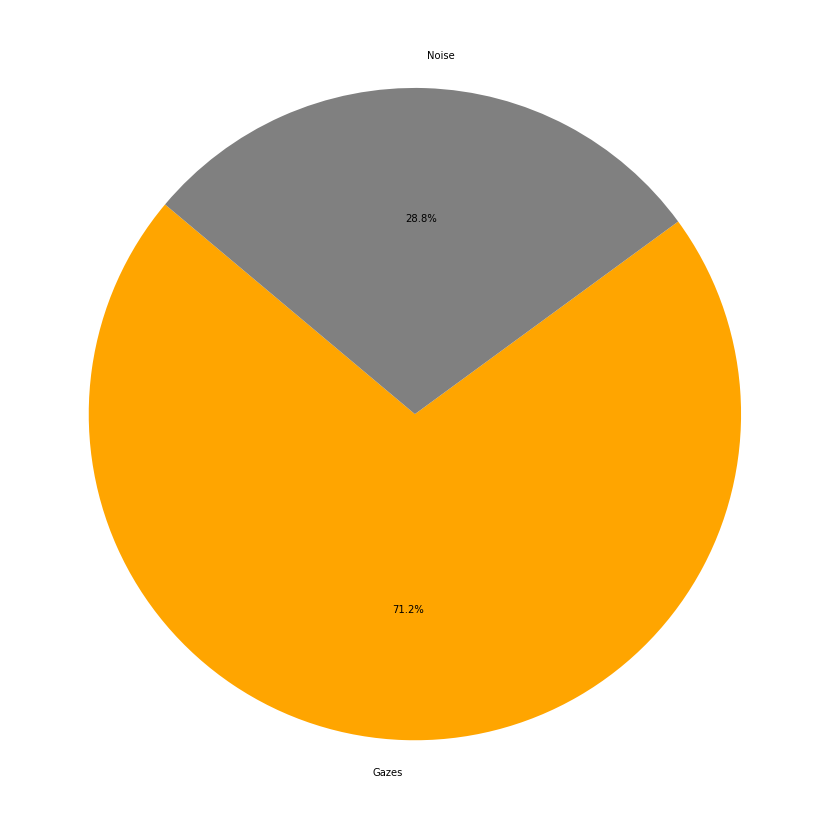

In [84]:
# Data to plot
labels = 'Gazes', 'Noise'
sizes = [gaze_sum, noise_sum]
colors = ['orange', 'gray']
explode = (0, 0, 0, 0)  # explode 1st slice

# Plot
plt.figure(figsize=(15,15))
plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=False, startangle=140)


plt.show()

In [85]:
gazes_interpolated = interpolated_data[interpolated_data.timeDiff>fixation_time]

ColliderAppearances = gazes_interpolated.groupby('ColliderName').timeDiff.sum()

Colliders_onlyHouses = ColliderAppearances.copy()
Colliders_onlyHouses = Colliders_onlyHouses.drop(labels=['NoHouse'])
Colliders_onlyHouses = Colliders_onlyHouses.sort_values()




sorted_interpolation = interpolated_data.groupby('ColliderName').Samples.sum().sort_values()

building14distance = round((sorted_interpolation['TaskBuilding_14'] \
                            - sorted_interpolation[0:-1].mean()) \
                           / sorted_interpolation[0:-1].std(),2)

print('The most viewed building after interpolation is currently {} sigma away from the mean!'.format(building14distance))
ColliderAppearances.sort_values()[-16:-1]


The most viewed building after interpolation is currently 1.61 sigma away from the mean!


ColliderName
Building_143       4.089515
Building_176       4.198139
TaskBuilding_14    4.306267
Building_186       4.457547
Building_142       4.626682
TaskBuilding_39    4.799289
TaskBuilding_18    5.197576
TaskBuilding_11    5.231802
TaskBuilding_46    5.663817
TaskBuilding_1     6.225784
TaskBuilding_41    7.168183
Building_64        7.513403
Building_94        7.729158
Building_145       8.431991
TaskBuilding_29    9.051493
Name: timeDiff, dtype: float64

(array([11.97508551,  6.1040481 ,  2.8959901 ,  1.73509752,  1.26491522,
         1.03190452,  0.80305473,  0.7073539 ,  0.61581399,  0.39944691,
         0.30790699,  0.3162288 ,  0.26213704,  0.22884979,  0.1581144 ,
         0.13314897,  0.1539535 ,  0.1539535 ,  0.14979259,  0.09153992,
         0.10818354,  0.0790572 ,  0.07073539,  0.09153992,  0.06241358,
         0.0748963 ,  0.07073539,  0.03744815,  0.04576996,  0.02912634,
         0.8571465 ]),
 array([4.96149063e-04, 3.27382088e-02, 6.49802685e-02, 9.72223282e-02,
        1.29464388e-01, 1.61706448e-01, 1.93948507e-01, 2.26190567e-01,
        2.58432627e-01, 2.90674686e-01, 3.22916746e-01, 3.55158806e-01,
        3.87400866e-01, 4.19642925e-01, 4.51884985e-01, 4.84127045e-01,
        5.16369104e-01, 5.48611164e-01, 5.80853224e-01, 6.13095284e-01,
        6.45337343e-01, 6.77579403e-01, 7.09821463e-01, 7.42063522e-01,
        7.74305582e-01, 8.06547642e-01, 8.38789701e-01, 8.71031761e-01,
        9.03273821e-01, 9.35515881e

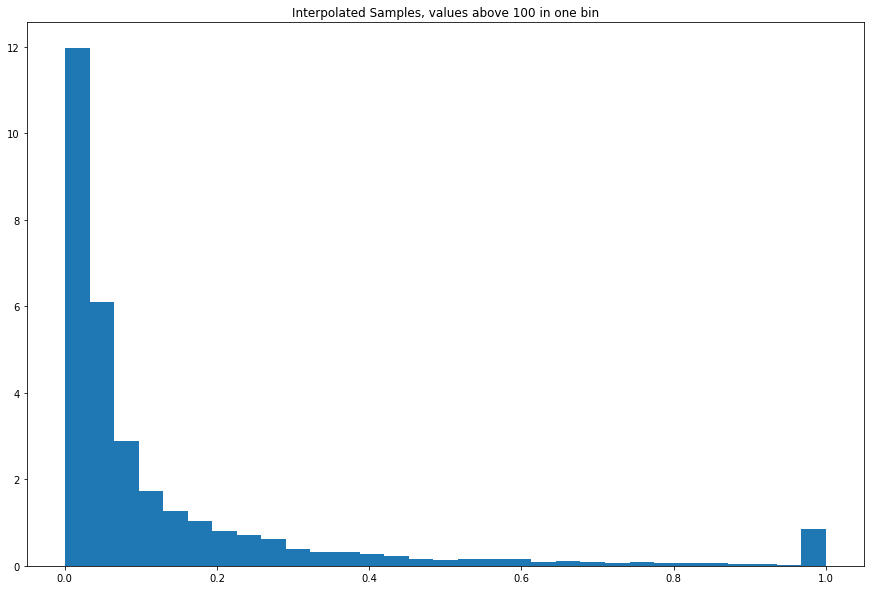

In [87]:
interpolation_til_100 = interpolated_data.copy()
interpolation_til_100 = interpolation_til_100.timeDiff
interpolation_til_100[interpolation_til_100>1] = 1

plt.figure(figsize=(15,10))
plt.title('Interpolated Samples, values above 100 in one bin')
plt.hist(interpolation_til_100, bins= 31, density=True)

## Graph Creation
* The graph creation involves the following steps:
    * creating the edge list
        * Remove non Fixations (SampleSize <= 21) 
        * Remove all noHouse hits 
        * Remove all noHit hits 
        * Remove all self repetitions
        * Shift the edgelist by one row and create chronology 
    * Use NetworkX to build the graph
    * Plot the graph onto the city map (using map coordinates)

Subject 1023 started - 1/1
	Mean/Std Degree: 4.40/2.68
	Maxmimum Degree of 12.00 is 2.83 sigma away from the mean
	Edge list saved
	Graph PNG saved
	Centrality Dataframe saved
Done


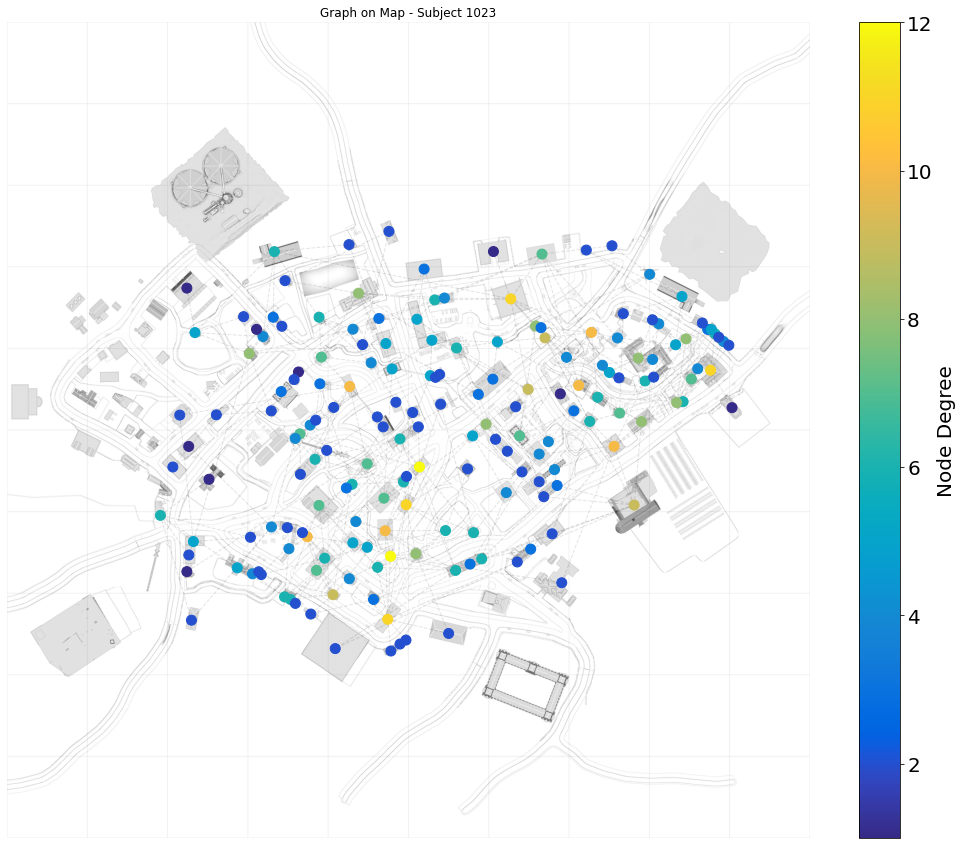

In [97]:
# --------- Preparation ---------
Plotting_bool = True # if you want to plot the graph
EdgeList_save_bool = True # if you want to save the edge list 
Graph_save_img_bool = True # if you want to save the graph as an image
plot_edges_bool = True # if you want to plot the graph's edges
save_centrality = True # if you want to save the centrality dataframe (node degree) as csv 

subcount = 0 # count subjects

fixation_time = 0.2333333

# implement parula color map scheme from matlab 
cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

# load the city map image
white_bg_img = cv2.imread("./ressources/map_white.png")

# Dataframe for degrees with colums = subject + houselist
centrality_df = pd.DataFrame(columns= [*['Subject'], *np.unique(houselist.target_collider_name)])



# --------- MAIN PART ---------
# load the files 
for subject in subIDs:
    subcount +=1
    print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))
    
    # get the data files according to the subject
    subject_folder = sorted([f for f in PROCESSED_DATA_FOLDER 
                             if f.startswith(str(subject)+'_interpolation_df')], key=str.lower)

    if len(subject_folder) != 0:
        
        # open the JSON file as dictionary
        with open(PROCESSED_DATA_PATH + subject_folder[0]) as f:
            try:
                interpolated_data = pd.read_csv(f)
            except:
                    print("\tCould not load subject " + str(subject) + " interpolation dataframe!")

    else:
        print('Subject ' + str(subject) + ' has no data file!')
        continue 

    edge_list = pd.DataFrame(columns=['Edge1','Edge2'])



    # --------- EDGE LIST CREATION ---------

    # filter out Clusters with <=21 hits, 'NoHouse' hits, 'NoHit' hits and self repititions (with unique)
    transition = interpolated_data[interpolated_data.timeDiff>fixation_time]
    transition = transition[transition.ColliderName!='NoHouse']
    #transition = transition[transition.ColliderName!='NoHit']
    unique_count = transition.ColliderName.groupby((transition['ColliderName'] 
                                            != transition['ColliderName'].shift()).cumsum()).cumcount() + 1

    # Assign filtered gaze hits to the edge list 
    edge_list.Edge1 = transition[unique_count==1].ColliderName
    edge_list.reset_index(inplace=True, drop=True)

    # shift the gaze hits by one and add the last entry of Edge1 to the first of Edge 2
    edge_list.Edge2[1:len(edge_list)-1] = edge_list.Edge1[0:len(edge_list)-2]
    edge_list.loc[0, 'Edge2'] = edge_list.Edge1[len(edge_list)-1]
    edge_list.loc[len(edge_list)-1, 'Edge2'] = edge_list.Edge1[0]

    # --------- GRAPH CREATION ---------

    # create graph from edgelist
    G = nx.Graph()
    G = nx.from_pandas_edgelist(edge_list, 'Edge1', 'Edge2')

    # Remove the NoHit Node
    G.remove_node('NoHit')
    
    degree_list = list(dict(G.degree).values())

    # Setting the node coordinates of each node of the graph


    # node list
    nodelist = list(G.nodes)

    # create the coordinate dictionary and assign coordinates from the houselist to the graph nodes
    node_pos = {}

    for node in nodelist:
        # assign node coordinates
        x = houselist['transformed_collidercenter_x'][houselist.target_collider_name==node].values[0]
        y = houselist['transformed_collidercenter_y'][houselist.target_collider_name==node].values[0]
        node_pos[node] = (x,y) 

    # set the graph's node coordinates attribute
    nx.set_node_attributes(G, node_pos, 'coord')


    
    
    # --------- ANALYSIS ---------

    # create degree list of the graph 
    sub_degree = dict(G.degree)
    
    
    mean_degree = np.nanmean(list(sub_degree.values()))
    std_degree = np.nanstd(list(sub_degree.values()))
    max_degree = max(list(sub_degree.values()))
    
    
    # add the subject ID to the dictionary
    sub_degree.update({'Subject': str(subject)})  
    # append the centrality df by the subjects degree list
    centrality_df = centrality_df.append(sub_degree, ignore_index=True)
    #centrality_df['betweenness'] = list(nx.betweenness_centrality(G))



    print('\tMean/Std Degree: ' + str("{:.2f}".format(mean_degree)) + '/' + str("{:.2f}".format(std_degree)))
    print('\tMaxmimum Degree of ' 
          + str("{:.2f}".format(max_degree)) 
          + ' is ' +
          "{:.2f}".format((max_degree-mean_degree)/std_degree)
          + ' sigma away from the mean')



    # --------- PLOTTING ---------    

    if Plotting_bool == True:

        # plot the map
        fig = plt.figure(figsize=(20,15))
        ax = plt.subplot2grid((10, 10), (0, 0), colspan=9,rowspan=10)
        plt.title("Graph on Map - Subject " + str(subject))
        plt.xlim(0, 4096)
        plt.ylim(0, 4096)
        ax.set_frame_on(False)
        plt.axis('off')
        plt.imshow(white_bg_img,aspect=ax.get_aspect(),
                 extent= ax.get_xlim() + ax.get_ylim(),
                 zorder=1, alpha=0.8)

        # Draw the graph 
        vmin = np.min(degree_list)
        vmax = np.max(degree_list)

        nx.draw_networkx_nodes(G,
                               node_pos, 
                               alpha = 1, 
                               node_size = 100, 
                               node_color=degree_list, 
                               cmap=parula_map)

        if plot_edges_bool == True:
            nx.draw_networkx_edges(G, 
                                   node_pos, 
                                   edge_color='k', 
                                   alpha=0.5, 
                                   width=1,
                                   style='dashed')



        sm = plt.cm.ScalarMappable(cmap=parula_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        cbar = plt.colorbar(sm)
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label('Node Degree', size=20)

    else:
        Graph_save_img_bool = False


    # --------- SAVING ---------

    # save the edge list 
    if EdgeList_save_bool == True:
        # saving the subject info dataframe
        try:
            edge_list.to_csv(PROCESSED_DATA_PATH
                            + str(subject)
                            + "_edgelist.csv", 
                            index=False)

            print("\tEdge list saved")
        except:
            print("\tCould not save subject " + str(subject) + " edge list!")



    # save the graph as png 
    if Graph_save_img_bool == True:
        # saving the subject info dataframe
        try:
            plt.savefig(PROCESSED_DATA_PATH + "Graphs/" + str(subject) + "_Graph.png",
                        format="PNG", 
                        facecolor='white',
                        transparent=False)

            
            print("\tGraph PNG saved")
        except:
            print("\tCould not save subject " + str(subject) + " Graph as PNG!")

            
# Add the mean over both axes to the centrality df and save it 


house_mean_dict = dict(centrality_df.loc[:,centrality_df.columns[1:]].mean(axis=0))
house_mean_dict.update({'Subject': 'Mean'})  
                 
house_std_dict = dict(centrality_df.loc[:,centrality_df.columns[1:]].std(axis=0))
house_std_dict.update({'Subject': 'STD'})  
                
centrality_df = centrality_df.append(house_mean_dict, ignore_index=True)
centrality_df = centrality_df.append(house_std_dict, ignore_index=True)

subject_mean = centrality_df.loc[:,centrality_df.columns[1:]].mean(axis=1)
subject_std = centrality_df.loc[:,centrality_df.columns[1:]].std(axis=1)
                 
centrality_df['Mean'] = subject_mean
centrality_df['STD'] = subject_std
    
        
if save_centrality == True: 
    # saving the subject info dataframe
    try:
        centrality_df.to_csv(PROCESSED_DATA_PATH
                        + "centrality_df.csv", 
                        index=False)

        print("\tCentrality Dataframe saved")
    except:
        print("\tCould not save centrality dataframe!")



    
print('Done')
    

## Plotting the average subject graph

Average Graph PNG saved
Done


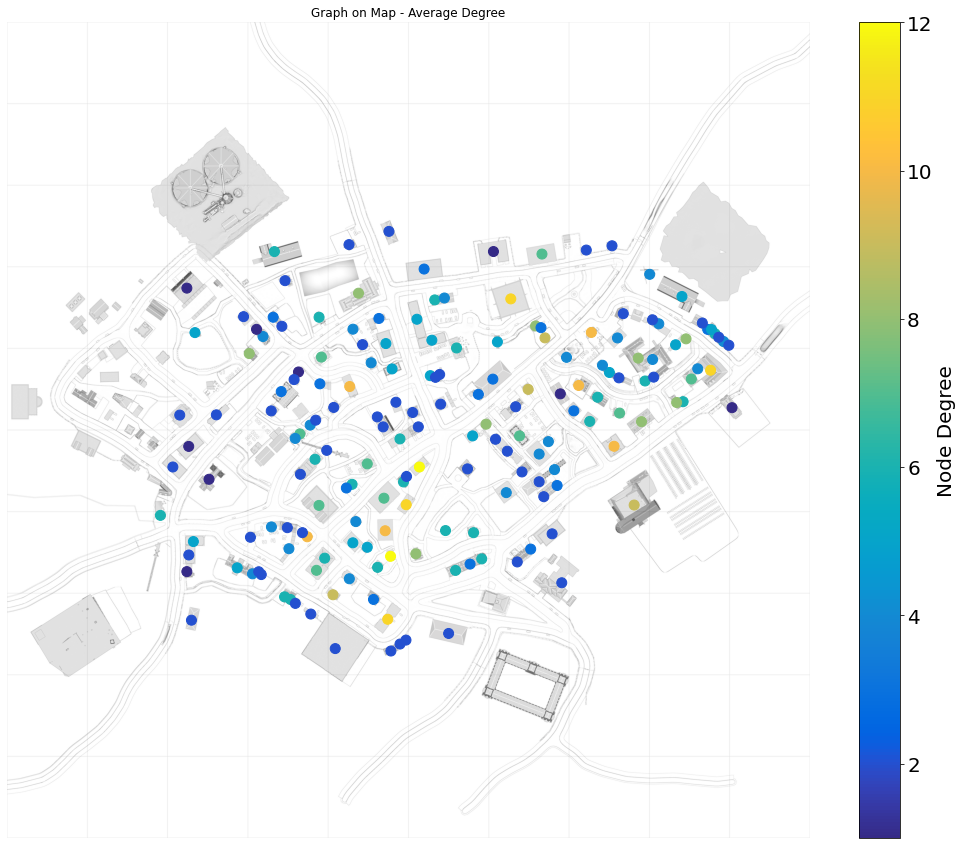

In [99]:
# --------- Preparation ---------
save_bool = True # if you want to save the graph as an image
plot_edges_bool = False # if you want to plot the graph's edges


# get the data files according to the subject
subject_folder = sorted([f for f in PROCESSED_DATA_FOLDER 
                         if f.startswith(str(1008)+'_edgelist')], key=str.lower)

if len(subject_folder) != 0:

    # open the JSON file as dictionary
    with open(PROCESSED_DATA_PATH + subject_folder[0]) as f:
        try:
            edge_list = pd.read_csv(f)
        except:
                print("\tCould not load subject " + str(subject) + " edgelist!")

    

# --------- GRAPH CREATION ---------

# create graph from edgelist
G = nx.Graph()
G = nx.from_pandas_edgelist(edge_list, 'Edge1', 'Edge2')
# Remove the NoHit Node
G.remove_node('NoHit')

# Setting the node coordinates of each node of the graph
# node list
nodelist = list(G.nodes)
nodearray = np.array(G.nodes)


# get the average degree over subjects and sort them according to the node order of the donor subject
mean_dict = centrality_df[centrality_df['Subject'] == 'Mean'].to_dict('records')[0]
mean_dict.pop('Mean')
mean_dict.pop('STD')
mean_dict.pop('Subject')

sorted_mean_degrees_dict = dict()
for node in nodelist:
    sorted_mean_degrees_dict[node] = mean_dict[node]
    
sorted_mean_degrees = list(sorted_mean_degrees_dict.values())


# create the coordinate dictionary and assign coordinates from the houselist to the graph nodes
node_pos = {}

for node in nodelist:
    # assign node coordinates
    x = houselist['transformed_collidercenter_x'][houselist.target_collider_name==node].values[0]
    y = houselist['transformed_collidercenter_y'][houselist.target_collider_name==node].values[0]
    node_pos[node] = (x,y) 

# set the graph's node coordinates attribute
nx.set_node_attributes(G, node_pos, 'coord')



# plot the map
fig = plt.figure(figsize=(20,15))
ax = plt.subplot2grid((10, 10), (0, 0), colspan=9,rowspan=10)
plt.title("Graph on Map - Average Degree")
plt.xlim(0, 4096)
plt.ylim(0, 4096)
ax.set_frame_on(False)
plt.axis('off')
plt.imshow(white_bg_img,aspect=ax.get_aspect(),
         extent= ax.get_xlim() + ax.get_ylim(),
         zorder=1, alpha=0.8)

# Draw the graph 
vmin = np.min(sorted_mean_degrees)
vmax = np.max(sorted_mean_degrees)

nx.draw_networkx_nodes(G,
                       node_pos, 
                       alpha = 1, 
                       node_size = 100, 
                       node_color=sorted_mean_degrees, 
                       cmap=parula_map)

if plot_edges_bool == True:
    nx.draw_networkx_edges(G, 
                           node_pos, 
                           edge_color='k', 
                           alpha=0.5, 
                           width=1,
                           style='dashed')
    
    
sm = plt.cm.ScalarMappable(cmap=parula_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Node Degree', size=20)


# ------- SAVING ---------


# save the graph as png 
if save_bool == True:
    # saving the subject info dataframe
    try:
        plt.savefig(PROCESSED_DATA_PATH + "Graphs/" + "AverageDegree_Graph.png",
                    format="PNG", 
                    facecolor='white',
                    transparent=False)


        print("Average Graph PNG saved")
    except:
        print("Could not save average Graph as PNG!")



print('Done')

In [100]:
mean_dict = centrality_df[centrality_df['Subject'] == 'Mean'].to_dict('records')[0]
mean_dict.pop('Mean')
mean_dict.pop('STD')
mean_dict.pop('Subject')

sorted_mean_degrees = np.array(list(mean_dict.values()))[np.argsort(list(dict(G.nodes).keys()))]


In [91]:
centrality_df

,Subject,Building_100,Building_101,Building_102,Building_103,Building_104,Building_105,Building_106,Building_107,Building_108,...,TaskBuilding_55,TaskBuilding_6,TaskBuilding_7,TaskBuilding_8,TaskBuilding_9,Windmill-TaskBuilding_10_1,crane_1,crane_2,Mean,STD
0,1023,2,2,3,NaN,2,NaN,NaN,NaN,3,...,NaN,3,2,NaN,4,2,NaN,NaN,3.355705,2.010358
1,Mean,2,2,3,NaN,2,NaN,NaN,NaN,3,...,NaN,3,2,NaN,4,2,NaN,NaN,3.355705,2.010358
2,STD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plotting the average node degree distribution

C:\Users\experiment\.conda\envs\graphs\lib\site-packages\numpy\lib\histograms.py:836: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\experiment\.conda\envs\graphs\lib\site-packages\numpy\lib\histograms.py:837: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'Frequency')

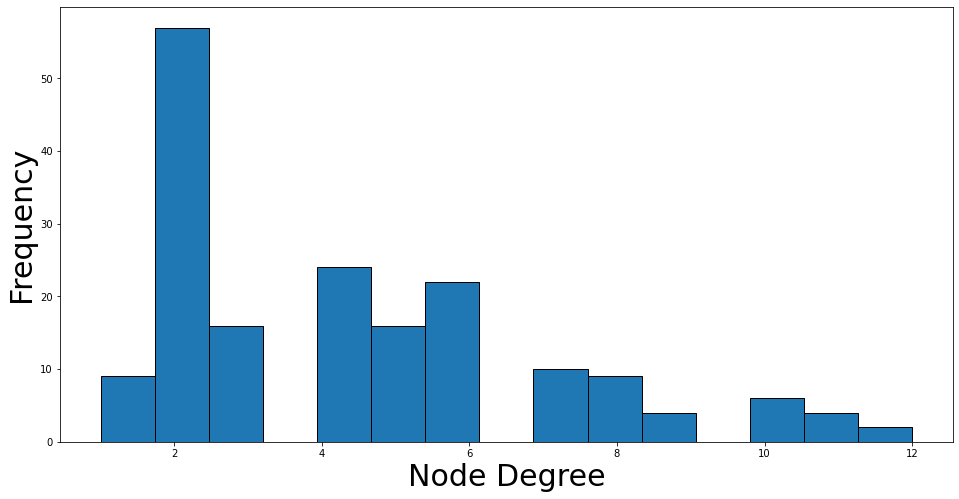

In [101]:
plt.figure(figsize=(16,8))
plt.hist(centrality_df.loc[len(centrality_df)-2][1:], bins=15, ec='black')
plt.xlabel("Node Degree", fontsize=30)
plt.ylabel("Frequency", fontsize=30)


In [102]:
mean_degree = centrality_df.loc[centrality_df[centrality_df.Subject == 'Mean'].index[0], 'Mean']
std_degree = centrality_df.loc[centrality_df[centrality_df.Subject == 'Mean'].index[0], 'STD']
max_degree = max(centrality_df[centrality_df.Subject == 'Mean'].iloc[0, 1:-2])

print('Mean/Std Degree: ' + str("{:.2f}".format(mean_degree)) + '/' + str("{:.2f}".format(std_degree)))
print('Maxmimum Degree of ' 
      + str("{:.2f}".format(max_degree)) 
      + ' is ' +
      "{:.2f}".format((max_degree-mean_degree)/std_degree)
      + ' sigma away from the mean')



Mean/Std Degree: 4.40/2.69
Maxmimum Degree of 12.00 is 2.83 sigma away from the mean
